In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
import yaml
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import metrics
from pathlib import Path
from cloudpathlib import S3Path
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker import Session
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.tuner import ContinuousParameter, IntegerParameter, HyperparameterTuner
import matplotlib.pyplot as plt

In [24]:
project_directory = Path.cwd() / "../"

In [25]:
boto_session = boto3.Session()
sagemaker_client = boto_session.client("sagemaker")
sagemaker_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client
)
region = boto_session.region_name
role = get_execution_role()
sagemaker_bucket = sagemaker_session.default_bucket()

In [26]:
params = yaml.safe_load(open('../code/params.yaml'))
hyperparameters = params["hyperparameters"]
directories = params["directories"]
datasets = params["datasets"]
sagemaker_params = yaml.safe_load(open('../params.yaml'))
train_params = sagemaker_params["train"]
model_params = sagemaker_params["model"]
inference_params = sagemaker_params["inference"]

In [27]:
train_s3_dir = train_params["inputs"]["train"]
test_s3_dir = train_params["inputs"]["test"]

In [28]:
!aws s3 cp $train_s3_dir ../data/train --recursive

download: s3://cad-alok-singh/us_in_season_corn_yield/8_stages/V0/train_test_2020/train/train.csv to ../data/train/train.csv


In [29]:
!aws s3 cp $test_s3_dir ../data/test --recursive

download: s3://cad-alok-singh/us_in_season_corn_yield/8_stages/V0/train_test_2020/test/test.csv to ../data/test/test.csv


In [30]:
sklearn = SKLearn(
    source_dir = str(project_directory / train_params['source_dir']),
    entry_point=train_params["entry_point"],
    framework_version=train_params["framework_version"], 
    instance_type="local",
    role=role,
    instance_count=train_params["instance_count"],
    tags=train_params["tags"],
    base_job_name=train_params["base_job_name"],
    # output_path="file://../sagemaker",
    output_path=train_params["output_path"],
    hyperparameters=hyperparameters,
    container_log_level=train_params["container_log_level"],
    volume_size=train_params["volume_size"],
    max_run=train_params["max_run"],
    max_wait=train_params["max_wait"],
    enable_sagemaker_metrics=train_params["enable_sagemaker_metrics"],
    metric_definitions=train_params["metric_definitions"]
)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')

sklearn.fit(
    job_name=f'{train_params["job_name"]}-{time_stamp}',
    inputs =     {
        "train": "file://../data/train",
        "test": "file://../data/test"
    },
    wait=train_params["wait"]
)

Using the short-lived AWS credentials found in session. They might expire while running.


Container wxegxt55ax-algo-1-hbi8h  Creating
Container wxegxt55ax-algo-1-hbi8h  Created
Attaching to wxegxt55ax-algo-1-hbi8h
wxegxt55ax-algo-1-hbi8h  | 2022-11-28 10:42:03,328 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
wxegxt55ax-algo-1-hbi8h  | 2022-11-28 10:42:03,337 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
wxegxt55ax-algo-1-hbi8h  | 2022-11-28 10:42:03,392 sagemaker_sklearn_container.training INFO     Invoking user training script.
wxegxt55ax-algo-1-hbi8h  | 2022-11-28 10:42:04,308 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
wxegxt55ax-algo-1-hbi8h  | /miniconda3/bin/python -m pip install -r requirements.txt
wxegxt55ax-algo-1-hbi8h  | Collecting PyYAML
wxegxt55ax-algo-1-hbi8h  |   Downloading PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2

In [31]:
sklearn.model_data

's3://sagemaker-eu-central-1-226275233641/cad-alok-singh/us_in_season_corn_yield/8_stages/V0/train_test_2020/model/Train/gda-yield-training-job-20221128-104159/model.tar.gz'

In [32]:
sklearn = SKLearn(
    source_dir = str(project_directory / train_params['source_dir']),
    entry_point=train_params["entry_point"],
    framework_version=train_params["framework_version"], 
    instance_type=train_params["instance_type"],
    role=role,
    instance_count=train_params["instance_count"],
    tags=train_params["tags"],
    base_job_name=train_params["base_job_name"],
    output_path=train_params["output_path"],
    hyperparameters=hyperparameters,
    container_log_level=train_params["container_log_level"],
    volume_size=train_params["volume_size"],
    max_run=train_params["max_run"],
    # max_wait=train_params["max_wait"],
    enable_sagemaker_metrics=train_params["enable_sagemaker_metrics"],
    metric_definitions=train_params["metric_definitions"],
    use_spot_instances=train_params["use_spot_instances"],
    security_group_ids= train_params["security_group_ids"],
    subnets= train_params["subnets"],
)
time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')

sklearn.fit(
    # job_name=f'{train_params["job_name"]}-{time_stamp}',
    inputs=train_params["inputs"],
    wait=train_params["wait"]
)

2022-11-28 10:44:28 Starting - Starting the training job...
2022-11-28 10:44:54 Starting - Preparing the instances for trainingProfilerReport-1669632267: InProgress
............
2022-11-28 10:46:52 Downloading - Downloading input data...
2022-11-28 10:47:32 Training - Training image download completed. Training in progress..2022-11-28 10:47:31,697 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-11-28 10:47:31,699 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-28 10:47:31,709 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-11-28 10:47:31,900 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [33]:
sklearn.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,test:mae,24.98
1,0.0,test:rmse,30.21


In [34]:
sklearn_inference = SKLearnModel(
    model_data=sklearn.model_data,
    role=role,
    source_dir =str(project_directory / model_params['source_dir']),
    entry_point=model_params["entry_point"],
    framework_version=model_params["framework_version"], 
    name=model_params["name"],
)

In [35]:
predictor = sklearn_inference.deploy(
    endpoint_name=inference_params["endpoint_name"],
    instance_type="local",
    initial_instance_count=1,
    tags=inference_params["tags"]
)

Using the short-lived AWS credentials found in session. They might expire while running.


Attaching to wb8wfl771n-algo-1-p2vzr
wb8wfl771n-algo-1-p2vzr  | 2022-11-28 10:48:55,075 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
wb8wfl771n-algo-1-p2vzr  | 2022-11-28 10:48:55,084 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
wb8wfl771n-algo-1-p2vzr  | 2022-11-28 10:48:55,086 INFO - sagemaker-containers - nginx config: 
wb8wfl771n-algo-1-p2vzr  | worker_processes auto;
wb8wfl771n-algo-1-p2vzr  | daemon off;
wb8wfl771n-algo-1-p2vzr  | pid /tmp/nginx.pid;
wb8wfl771n-algo-1-p2vzr  | error_log  /dev/stderr;
wb8wfl771n-algo-1-p2vzr  | 
wb8wfl771n-algo-1-p2vzr  | worker_rlimit_nofile 4096;
wb8wfl771n-algo-1-p2vzr  | 
wb8wfl771n-algo-1-p2vzr  | events {
wb8wfl771n-algo-1-p2vzr  |   worker_connections 2048;
wb8wfl771n-algo-1-p2vzr  | }
wb8wfl771n-algo-1-p2vzr  | 
wb8wfl771n-algo-1-p2vzr  | http {
wb8wfl771n-algo-1-p2vzr  |   include /etc/nginx/mime.types;
wb8wfl771n-algo-1-p2vzr  |   default_type application/octet-stream;
wb8wf

In [36]:
df = pd.read_csv("../data/test/test.csv")
df = df.drop(datasets["drop_columns"], axis=1)

In [37]:
X_test = df.drop(datasets["y_column"], axis=1)
y_true = df[datasets["y_column"]]

In [38]:
y_pred = predictor.predict(X_test)

wb8wfl771n-algo-1-p2vzr  | 2022-11-28 10:50:13,892 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
wb8wfl771n-algo-1-p2vzr  | 172.18.0.1 - - [28/Nov/2022:10:50:16 +0000] "POST /invocations HTTP/1.1" 200 49968 "-" "python-urllib3/1.26.11"


In [39]:
mae = metrics.mean_absolute_error(y_true, y_pred)
rmse = (np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
r2 = metrics.r2_score(y_true, y_pred)

print("Testing performance")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

Testing performance
MAE: 24.98
RMSE: 30.21
R2: 0.34


Text(0, 0.5, 'Yield')

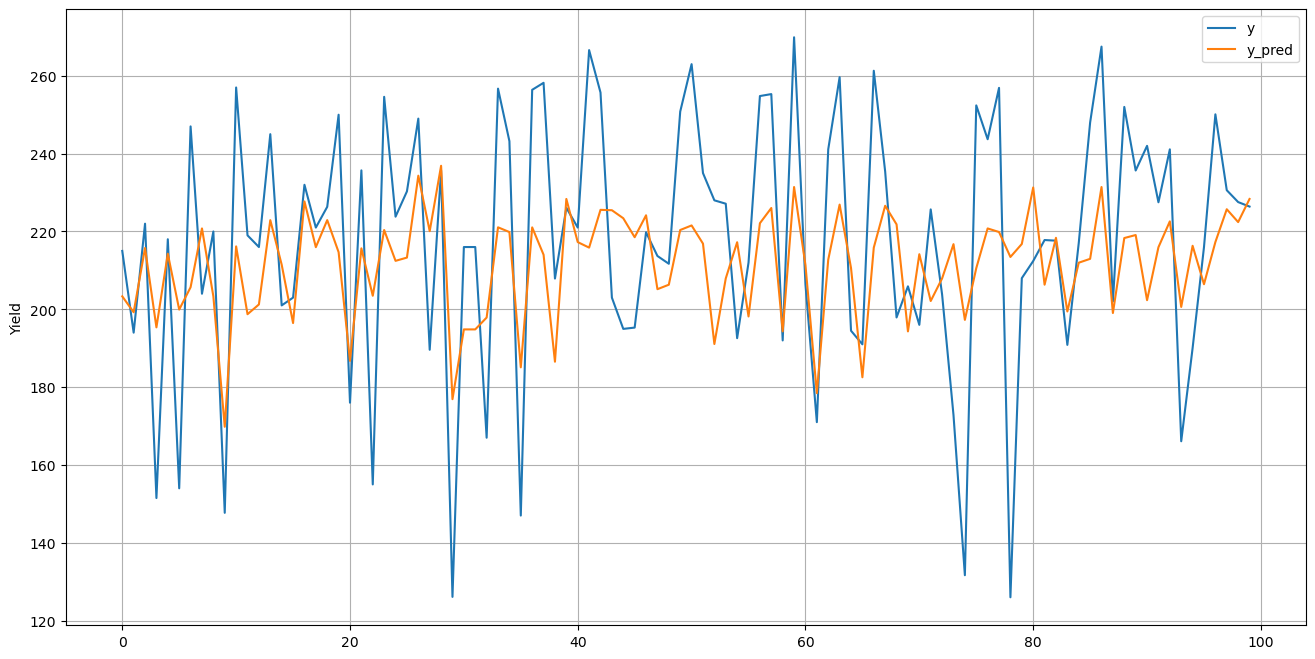

In [40]:
plt.figure(figsize=(16,8))
plt.plot(y_true[:100], label="y")
plt.plot(y_pred[:100], label="y_pred")
plt.legend()
plt.grid(which="both")
plt.ylabel('Yield')

In [41]:
%tensorboard --logdir ../sagemaker/output/

Reusing TensorBoard on port 6007 (pid 59872), started 0:08:33 ago. (Use '!kill 59872' to kill it.)

In [42]:
predictor.delete_model()
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/joshuacole/opt/anaconda3/envs/sagemaker-poc/lib/python3.10/site-packages/sagemaker/local/image.py", line 854, in run
    _stream_output(self.process)
  File "/Users/joshuacole/opt/anaconda3/envs/sagemaker-poc/lib/python3.10/site-packages/sagemaker/local/image.py", line 916, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 130

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/joshuacole/opt/anaconda3/envs/sagemaker-poc/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/joshuacole/opt/anaconda3/envs/sagemaker-poc/lib/python3.10/site-packages/sagemaker/local/image.py", line 859, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/private/var/folders/9s/vk4whfgs7r7_9jw8m0plbd1r0000gn/T/tmpd